In [1]:
# Gerekli kütüphanelerin içe aktarılması
import yfinance as yf  # Finansal veri indirmek için
import numpy as np  # Sayısal işlemler için
from sklearn.preprocessing import MinMaxScaler  # Veri ölçeklendirmek için
from tensorflow.keras.models import Sequential  # Model oluşturmak için
from tensorflow.keras.layers import LSTM, Dense, Dropout , Activation, BatchNormalization # Model katmanları
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau # Model eğitimini durdurmak için
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import mean_squared_error  , mean_absolute_error , r2_score  # Hata ölçümü için
import mplfinance as mpf  # Finansal verileri görselleştirmek için
import pandas as pd  # Veri işleme için
import plotly.graph_objects as go

In [2]:
#tensorflow gpu var mı yok mu kontrolü
import tensorflow as tf
tf.test.gpu_device_name()


'/device:DML:0'

In [3]:
# Veri Toplama
btc_data = yf.download('BTC-USD', period='3600d')  # Bitcoin verilerini yfinance ile indirme
#btc_data

[*********************100%***********************]  1 of 1 completed


In [4]:
# İndirilen Verileri Mum Çubukları ile Görselleştirme
#mpf.plot(btc_data, type='candle', volume=True, style='yahoo', title='BTC-USD') 

In [5]:
# Veri Hazırlama
btc_df = btc_data[['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume']]  # İlgili sütunların seçilmesi


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Ölçekleyici tanımlama
scaled_data = scaler.fit_transform(btc_df)  # Verilerin ölçeklendirilmesi


In [7]:

# Zaman serisi veri seti oluşturma fonksiyonu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:]  # Girdi verileri
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0:])  # Çıktı verileri
    return np.array(dataX), np.array(dataY)

time_step = 7  # Zaman adımı
X, y = create_dataset(scaled_data, time_step)  # X ve y veri setlerinin oluşturulması




In [8]:
# Veri setini eğitim ve test setlerine ayırma
test_size = 7  # Test setinin boyutu
train_size = int(len(X) - test_size)  # Eğitim setinin boyutu
X_train, X_test = X[0:train_size,:,:], X[train_size:len(X),:,:]  # Eğitim ve test girdileri
y_train, y_test = y[0:train_size,:], y[train_size:len(y),:]  # Eğitim ve test çıktıları


In [9]:
units1 = 256  # İlk LSTM katmanı için birim sayısı
units2 = units1*2  # İkinci LSTM katmanı için birim sayısı
units3 = units1  # Yoğun katmanlar için birim sayısı
units3 = units1/2  # Yoğun katmanlar için birim sayısı
units4 = units3/2  # Yoğun katmanlar için birim sayısı
units5 = units4/2  # Yoğun katmanlar için birim sayısı


dropout = 0.2  # Dropout oranı
batch_size = X_train.shape[0] / 1 # Batch boyutu
batch_size = int(batch_size)
activation = 'relu'  # Aktivasyon fonksiyonu
epochs = 100  # Eğitim sayısı

In [10]:
batch_size

3407

In [11]:
input_shape=(X_train.shape[1], X_train.shape[2])
input_shape

(7, 6)

In [12]:
output_shape = y_train.shape[1]
output_shape

6

In [13]:
model = Sequential()  # Model oluşturma
model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))  # LSTM katmanı



model.add(LSTM(units1))


model.add(Dropout(dropout))




model.add(Dense(output_shape))  # Yoğun katman
model.add(Activation(activation))  # Aktivasyon fonksiyonu


model.compile(optimizer='adam', loss='mean_squared_error' )  # Model derleme



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
model.summary()  # Model özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            269312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 796,166
Trainable params: 796,166
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stopping = EarlyStopping(monitor='val_loss',  # İzlenecek metrik
                               patience=5,          # Metrikte iyileşme olmadığı durumda kaç epoch bekleyeceği
                               verbose=1,           # Eğitim durdurulduğunda bilgi vermesi
                               restore_best_weights=True)  # En iyi ağırlıkları geri yükleme
# ReduceLROnPlateau callback'ini ayarlama
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # Öğrenme oranını ne kadar azaltacağı
                              patience=3,  # Kaç epoch boyunca iyileşme olmadığında öğrenme oranını azaltacağı
                              min_lr=0.001,  # Öğrenme oranının düşebileceği minimum değer
                              verbose=1)

In [16]:

# Modeli Eğitme ve Tahmin Yapma
history = model.fit(X_train, y_train, 
                    validation_data=(X_test,y_test) , 
                    epochs=epochs, batch_size= batch_size, 
                    verbose=1,  

                    
                    #callbacks=[early_stopping , reduce_lr],
                        )  # Model eğitimi


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3407 samples, validate on 7 samples
Epoch 1/100
3407/3407 [==============================] - 1s 354us/sample - loss: 0.0847 - val_loss: 0.2146
Epoch 2/100
3407/3407 [==============================] - 0s 17us/sample - loss: 0.0626 - val_loss: 0.1404
Epoch 3/100
3407/3407 [==============================] - 0s 18us/sample - loss: 0.0407 - val_loss: 0.0722
Epoch 4/100
3407/3407 [==============================] - 0s 19us/sample - loss: 0.0217 - val_loss: 0.0307
Epoch 5/100
3407/3407 [==============================] - 0s 18us/sample - loss: 0.0113 - val_loss: 0.0350
Epoch 6/100
3407/3407 [==============================] - 0s 18us/sample - loss: 0.0146 - val_loss: 0.0289
Epoch 7/100
3407/3407 [==============================] - 0s 18us/sample - loss: 0.0129 - val_loss: 0.0102
Epoch 8/100
3407/3407 [==============================] - 0s 17us/sample - loss: 0.0062 - val_loss: 0.0058
Epoch 9/100


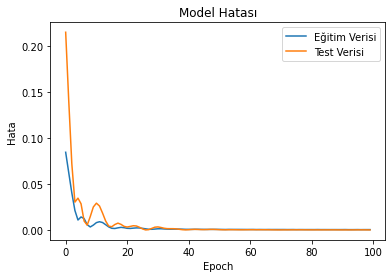

In [17]:
# Modelin Eğitim ve Test Hata Grafiği
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Eğitim Verisi')
plt.plot(history.history['val_loss'], label='Test Verisi')
plt.title('Model Hatası')
plt.ylabel('Hata')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [18]:
model.evaluate(X_test, y_test)  # Test verileri ile modelin performansını ölçme
# bu ne  ? yüksek çıkması iyi mi kötü mü ?


7/7 [==============================] - 0s 2ms/sample - loss: 6.2015e-04


0.0006201486685313284

In [19]:
predictions = model.predict(X_test).squeeze() # Test verisi üzerinde tahmin yapma


In [20]:
predictions_df = pd.DataFrame(predictions , columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])  # Tahminlerin DataFrame'e dönüştürülmesi
predictions_df

,Open,High,Low,Close,Adj Close,Volume
0,0.619346,0.624189,0.614198,0.618112,0.615984,0.091786
1,0.615398,0.620533,0.610636,0.614500,0.612179,0.091486
2,0.609200,0.614446,0.604643,0.608418,0.606147,0.091526
3,0.603220,0.608265,0.598588,0.602401,0.600227,0.091759
4,0.598951,0.603884,0.594252,0.598049,0.595912,0.090985
5,0.597334,0.601712,0.592420,0.596065,0.594329,0.090808
6,0.597723,0.601094,0.592340,0.596123,0.594549,0.091473


In [21]:
y_test_df = pd.DataFrame(y_test, columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])  # Gerçek değerlerin DataFrame'e dönüştürülmesi
y_test_df

,Open,High,Low,Close,Adj Close,Volume
0,0.614146,0.604269,0.593238,0.583618,0.583618,0.089277
1,0.583942,0.582048,0.579219,0.588636,0.588636,0.083310
2,0.589269,0.587245,0.594124,0.592072,0.592072,0.063692
3,0.592207,0.583902,0.594681,0.589946,0.589946,0.052672
4,0.590148,0.612408,0.598910,0.617889,0.617889,0.072920
5,0.618034,0.612208,0.623160,0.622388,0.622388,0.032531
6,0.622643,0.620979,0.627172,0.621135,0.621135,0.048020


In [22]:
MSE = mean_squared_error( predictions , y_test)  # Hata ölçümü
MAE = mean_absolute_error( predictions ,y_test)  # Hata ölçümü
R2 = r2_score(predictions ,y_test)  # Hata ölçümü
print('MSE: ', MSE)
print('MAE: ', MAE)
print('R2: ', R2)


MSE:  0.0006201486951780554
MAE:  0.021965583620540314
R2:  -1609.4772183790835


In [23]:
# Sonuçların Değerlendirilmesi
predictions_scaled = scaler.inverse_transform(predictions)  # Tahminlerin ölçeklendirilmesinin tersine çevrilmesi
y_test_scaled = scaler.inverse_transform(y_test)  # Gerçek test verilerinin ölçeklendirilmesinin tersine çevrilmesi


MSE = mean_squared_error( predictions_scaled , y_test_scaled)  # Hata ölçümü
MAE = mean_absolute_error( predictions_scaled ,y_test_scaled)  # Hata ölçümü
R2 = r2_score(predictions_scaled ,y_test_scaled)  # Hata ölçümü
print('MSE: ', MSE)
print('MAE: ', MAE)
print('R2: ', R2)


MSE:  2.342181889846592e+19
MAE:  1649528169.9962797
R2:  -1609.4841041017944


In [24]:
predictions_scaled_df = pd.DataFrame(predictions_scaled, columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])  # Tahminlerin DataFrame'e dönüştürülmesi
predictions_scaled_df

,Open,High,Low,Close,Adj Close,Volume
0,41903.988281,43017.316406,40837.906250,41831.910156,41688.464844,3.221943e+10
1,41637.984375,42766.550781,40602.058594,41588.480469,41432.058594,3.211393e+10
2,41220.425781,42349.132812,40205.257812,41178.589844,41025.546875,3.212805e+10
3,40817.531250,41925.292969,39804.343750,40773.144531,40626.667969,3.220981e+10
4,40529.949219,41624.816406,39517.257812,40479.832031,40335.867188,3.193810e+10
5,40421.003906,41475.847656,39395.953125,40346.195312,40229.191406,3.187600e+10
6,40447.207031,41433.507812,39390.656250,40350.078125,40243.984375,3.210942e+10


In [25]:
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])  # Gerçek değerlerin DataFrame'e dönüştürülmesi
y_test_scaled_df

,Open,High,Low,Close,Adj Close,Volume
0,41553.652344,41651.207031,39450.117188,39507.367188,39507.367188,3.133871e+10
1,39518.714844,40127.351562,38521.894531,39845.550781,39845.550781,2.924455e+10
2,39877.593750,40483.785156,39508.796875,40077.074219,40077.074219,2.235953e+10
3,40075.550781,40254.480469,39545.664062,39933.808594,39933.808594,1.849178e+10
4,39936.816406,42209.386719,39825.691406,41816.871094,41816.871094,2.559812e+10
5,41815.625000,42195.632812,41431.281250,42120.054688,42120.054688,1.142294e+10
6,42126.125000,42797.175781,41696.910156,42035.593750,42035.593750,1.685897e+10


In [26]:
def prepare_data_for_forecasting(latest_data, time_step):
    # Son kullanılabilir verileri al ve ölçeklendir
    last_scaled_data = scaler.transform(latest_data)

    # Son verileri model girdisi olarak hazırla
    X = []
    for i in range(len(last_scaled_data) - time_step):
        X.append(last_scaled_data[i:i + time_step, 0:])

    return np.array(X)


In [27]:
def predict_future_prices(model, prepared_data, days_to_predict):
    predictions = []

    # Son verileri kullanarak gelecek günler için tahmin yap
    current_batch = prepared_data[-1].reshape(1, prepared_data.shape[1], 6)

    for i in range(days_to_predict):
        # Tahmin yap ve sonucu sakla
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        
        # Sonraki tahmin için girdiyi güncelle
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    return scaler.inverse_transform(predictions)


In [28]:
days_to_predict = 30  # Kaç gün sonrası için tahmin yapılacağı

btc_data_son_x = btc_data[-days_to_predict:]


#btc_datadan son x günü sil (göz ile test için)
btc_data = btc_data[:-days_to_predict]


# Son kullanılabilir verileri al (örneğin son 100 gün)
latest_data = btc_data

# Verileri hazırla
prepared_data = prepare_data_for_forecasting(latest_data, time_step=time_step) # Son 100 gündeki verileri kullanarak gelecek 30 gün için tahmin yap

# Gelecek x gün için tahmin yap
future_predictions = predict_future_prices(model, prepared_data, days_to_predict=days_to_predict) # Son 100 gündeki verileri kullanarak gelecek 30 gün için tahmin yapar



In [29]:
# Tahmin edilen verileri df yap
future_predictions_df = pd.DataFrame(future_predictions,columns=['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume'])

#btc_datanın son tarihinden başlayarak x gün boyunca tarihleri oluştur
future_predictions_df['Date'] = pd.date_range(start=btc_data.index[-1], periods=len(future_predictions_df), freq='D')

# Tarihi indeks olarak ayarla
future_predictions_df.set_index('Date', inplace=True)
future_predictions_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-30,42946.191285,44073.443410,41855.048694,42848.815778,42745.940543,3.314405e+10
2023-12-31,42814.045525,43922.334455,41710.004580,42721.009004,42626.207299,3.391738e+10
2024-01-01,42747.962605,43844.053574,41631.979189,42656.910808,42571.415753,3.456964e+10
2024-01-02,42681.176933,43761.100610,41555.844151,42593.001397,42514.941218,3.522950e+10
2024-01-03,42671.996965,43750.783606,41537.307645,42579.814633,42511.298088,3.553745e+10
2024-01-04,42628.197353,43697.796553,41486.224713,42540.804627,42475.758494,3.610772e+10
2024-01-05,42594.573612,43657.174372,41437.324171,42510.422451,42448.171929,3.672469e+10
2024-01-06,42612.082213,43684.099136,41445.785373,42536.735729,42472.745983,3.721552e+10
2024-01-07,42570.563538,43636.303285,41401.233826,42495.179147,42433.414643,3.739021e+10


In [30]:
btc_data_son_x

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810
2024-01-01,42280.234375,44175.437500,42214.976562,44167.332031,44167.332031,18426978443
2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,44957.968750,39335274536
2024-01-03,44961.601562,45503.242188,40813.535156,42848.175781,42848.175781,46342323118
2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,30448091210
2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,32336029347
2024-01-06,44178.953125,44227.632812,43475.156250,43989.195312,43989.195312,16092503468
2024-01-07,43998.464844,44495.570312,43662.230469,43943.097656,43943.097656,19330573863
2024-01-08,43948.707031,47218.000000,43244.082031,46970.503906,46970.503906,42746192015


In [31]:
#görselleştirme yan yana
fig = go.Figure()

fig.add_trace(go.Scatter(x=btc_data_son_x.index, y=btc_data_son_x['Close'], name='Gerçek Veri'))
fig.add_trace(go.Scatter(x=future_predictions_df.index, y=future_predictions_df['Close'], name='Tahmin'))

fig.update_layout(title='BTC-USD', xaxis_title='Tarih', yaxis_title='Kapanış Fiyatı')
fig.show()

